In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load the dataset

In [196]:
df = pd.read_csv('tempdata.csv', parse_dates=True, index_col=0)
df = df.rename(columns = lambda x: 'S_'+x)

# Define the cutoff date
cutoff_date = "2020-09-01"

# Select rows past the cutoff date
df = df[df.index >=  pd.Timestamp(cutoff_date)]

# Define the cutoff date
cutoff_date = "2024-08-31"

# Select rows past the cutoff date
df = df[df.index <=  pd.Timestamp(cutoff_date)]

# Calculate the percentage of non-missing data for each study site
non_missing_percentage = df.notna().mean() * 100

# Filter study sites with at least 90% non-missing data
selected_sites = non_missing_percentage[non_missing_percentage >= 90].index
df_selected = df[selected_sites]

# artifical gaps 
df = df_selected.copy()

Xtrue = df.values.copy()

Text(0.5, 0, 'Station')

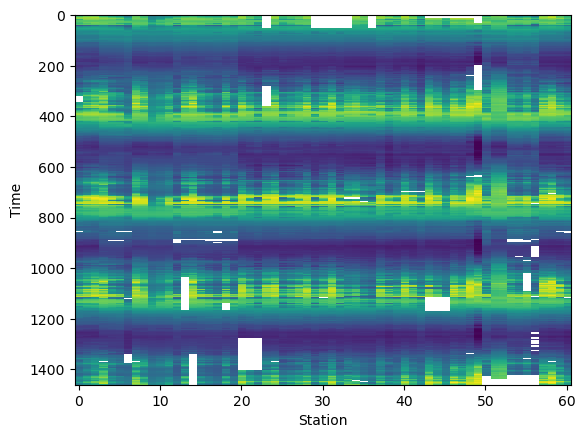

In [197]:
plt.imshow(Xtrue, aspect='auto', interpolation='nearest')
plt.ylabel('Time')
plt.xlabel('Station')

In [198]:
def missing_data_fraction(X):
    N = X.size
    m = np.isnan(X).sum()
    missing_data = m / N * 100
    return missing_data
    
print (f'Initial missing data {missing_data_fraction(Xtrue):0.1f}%')

Initial missing data 2.5%


## Introduce artifical gaps

Prepare the dataset by introducing artificial gaps

In [199]:
p = 56 # gap length
q = 24 # number of sites that have missing data

np.random.seed(4152)

gaps = {}
# randomly set a n-day contiguous segment as missing for each column
random_columns = np.random.choice(df.columns, size=q, replace=False)

N = len(df.values.flatten())
m = df.isnull().values.flatten().sum()
missing_data = m / N * 100

for col in random_columns:
    # Randomly select the start of the n-day segment
    start_idx = np.random.randint(0, len(df) - p)
    end_idx = start_idx + p

    gaps[col] = [start_idx, end_idx]

    # Set the values in this range to NaN
    df.iloc[start_idx:end_idx, df.columns.get_loc(col)] = np.nan
    
X = df.values

Text(0.5, 0, 'Station')

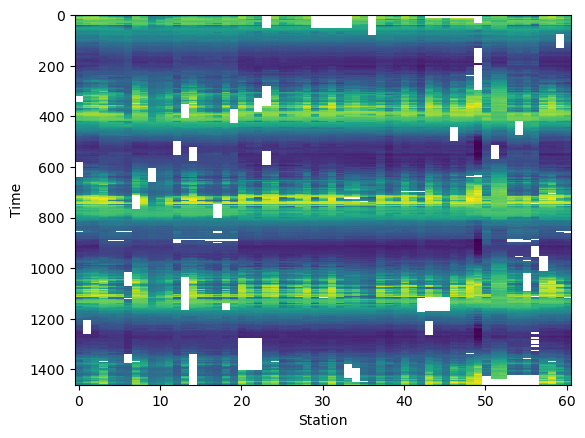

In [200]:
plt.imshow(X, aspect='auto', interpolation='nearest')
plt.ylabel('Time')
plt.xlabel('Station')

In [201]:
print (f'Artificial missing data {missing_data_fraction(X):0.1f}%')

Artificial missing data 3.9%


Identify missing observations

In [202]:
mask = np.isnan(X)

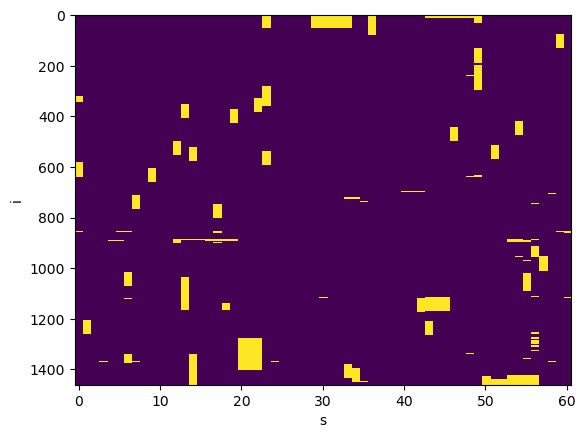

In [203]:
plt.imshow(mask, aspect='auto', interpolation='nearest')
plt.xlabel('s')
plt.ylabel('i')
plt.show()

In [204]:
# Count missing per column
col_missing_count = mask.sum(axis=0)

# Get col and row indices for missing
missing_rows, missing_cols = np.where(mask)

In [205]:
Ximp = X.copy()

In [207]:
# 1. Make initial guess for missing values
col_means = np.nanmean(X, axis=0)
Ximp[missing_rows, missing_cols] = np.take(col_means, missing_cols)

In [208]:
error = Xtrue - Ximp
MAE = np.nanmean(abs(error))
RMSE = np.sqrt(np.nanmean((error)**2))
print(MAE, RMSE)

0.06982506172103002 0.682397283867648


In [209]:
# 2. misscount_idx: sorted indices of cols in X based on missing count
misscount_idx = np.argsort(col_missing_count) # k


Stop when difference between the newly imputed data matrix and the previous one increases for the first time

In [210]:
iter_count = 0
gamma_new = 0
gamma_old = np.inf

col_index = np.arange(Ximp.shape[1])

In [211]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_jobs=-1)

In [212]:
from tqdm.notebook import tqdm

while(gamma_new < gamma_old):
    
    #4. store previously imputed matrix
    Ximp_old = np.copy(Ximp)
    
    if iter_count != 0:
        gamma_old = gamma_new
        
    #5. loop for s in k
    for s in tqdm(misscount_idx):
        # Column indices other than the one being imputed
        s_prime = np.delete(col_index, s)
    
        # Get indices of rows where 's' is observed and missing
        obs_rows = np.where(~mask[:, s])[0]
        mis_rows = np.where(mask[:, s])[0]
    
        # If no missing, then skip
        if len(mis_rows) == 0:
            continue
    
        # Get observed values of 's'
        yobs = Ximp[obs_rows, s]
    
        # Get 'X' for both observed and missing 's' column
        xobs = Ximp[np.ix_(obs_rows, s_prime)]
        xmis = Ximp[np.ix_(mis_rows, s_prime)]
    
        # 6. Fit a random forest over observed and predict the missing
        rf_regressor.fit(X=xobs, y=yobs)
        
        # 7. predict ymis(s) using xmis(x)
        ymis = rf_regressor.predict(xmis)
        
        # 8. update imputed matrix using predicted matrix ymis(s)
        Ximp[mis_rows, s] = ymis
    
    # 9. Update gamma (stopping criterion)
    gamma_new = np.sum((Ximp - Ximp_old) ** 2) / np.sum(Ximp ** 2)
    iter_count += 1

    error = Xtrue - Ximp
    MAE = np.nanmean(abs(error))
    RMSE = np.sqrt(np.nanmean((error)**2))

    print('Statistics:')
    print(f'iteration {iter_count}')
    print(f'gamma = {gamma_new}')
    print(f'MAE = {MAE:.3f}, RMSE = {RMSE:.3f}')
    

  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1
gamma = 0.012440441750857715
MAE = 0.005, RMSE = 0.071


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2
gamma = 0.0003019131506739379
MAE = 0.005, RMSE = 0.066


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3
gamma = 4.236300594248872e-05
MAE = 0.005, RMSE = 0.066


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 4
gamma = 1.3878660172508531e-05
MAE = 0.005, RMSE = 0.066


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 5
gamma = 6.486537012946997e-06
MAE = 0.005, RMSE = 0.066


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 6
gamma = 6.377247772296606e-06
MAE = 0.005, RMSE = 0.066


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 7
gamma = 6.1958677000452675e-06
MAE = 0.005, RMSE = 0.066


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 8
gamma = 6.337741216141083e-06
MAE = 0.005, RMSE = 0.066


Text(0, 0.5, 'i')

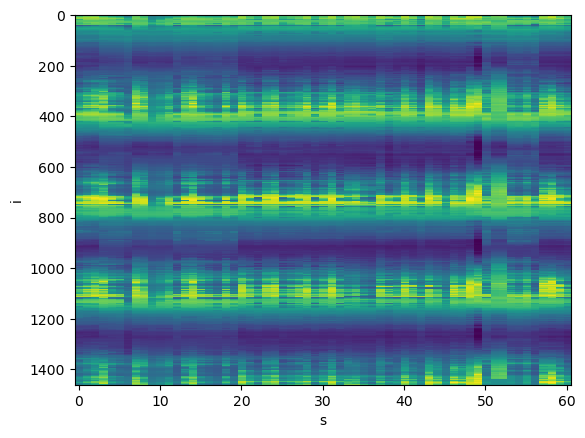

In [189]:
plt.imshow(Ximp, aspect='auto', interpolation='nearest')
plt.xlabel('s')
plt.ylabel('i')